<a href="https://colab.research.google.com/github/ArthurYama/cognitive_AI_coursework/blob/main/Cog_AI_coursework_spatial_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 13187, done.
remote: Counting objects: 100% (1489/1489), done.
remote: Compressing objects: 100% (376/376), done.
remote: Total 13187 (delta 1166), reused 1218 (delta 1098), pack-reused 11698 (from 1)
Receiving objects: 100% (13187/13187), 10.67 MiB | 9.92 MiB/s, done.
Resolving deltas: 100% (9970/9970), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793133 sha256=75f1014647bd6a56fae7a42d14978a3cf78b0ce9a8a4e9cad68a025e6d007079
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built gym
  Attempting uninstall: gym
    Found existin

In [2]:
# @title Import common packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.nn import init
from torch.nn import functional as F
import math
import numpy as np
import numpy.matlib

In [3]:
# @title Making standard Leaky RNN
class LeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


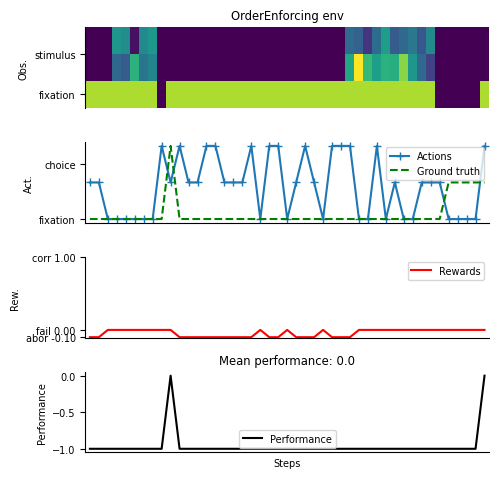

In [4]:
# @title Import the task from the neurogym library and make supervised dataset

import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'PerceptualDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

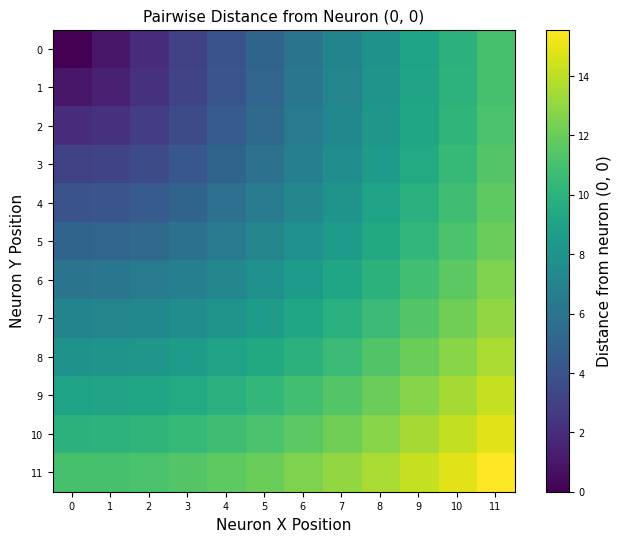

In [5]:
# @title Visualise the pairwise distance from neuron (0, 0)
# Instantiate the networks and print information
hidden_size = 144

net_leaky = RNNNet(input_size=input_size, hidden_size=hidden_size,
            output_size=output_size, dt=env.dt)

# The 144 hidden neurons lie on a 12x12 grid
w = int(np.sqrt(net_leaky.rnn.h2h.weight.data.shape[0]))
X, Y = np.meshgrid(range(w), range(w))

def calculate_distances(x, y, X, Y):
    distances = np.sqrt((x - X) ** 2 + (y - Y) ** 2)
    return distances

def calculate_distance(pos1, pos2):
    x1, y1 = pos1
    x2, y2 = pos2
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


distances = calculate_distances(0, 0, X, Y)

# Plot the distances as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(distances, cmap='viridis', origin='upper')
cbar = plt.colorbar()
cbar.set_label('Distance from neuron (0, 0)', fontsize = 11)
plt.title('Pairwise Distance from Neuron (0, 0)', fontsize = 11)
plt.xlabel('Neuron X Position', fontsize = 11)
plt.ylabel('Neuron Y Position', fontsize = 11)
plt.xticks(range(w))
plt.yticks(range(w))
plt.grid(False)
plt.show()

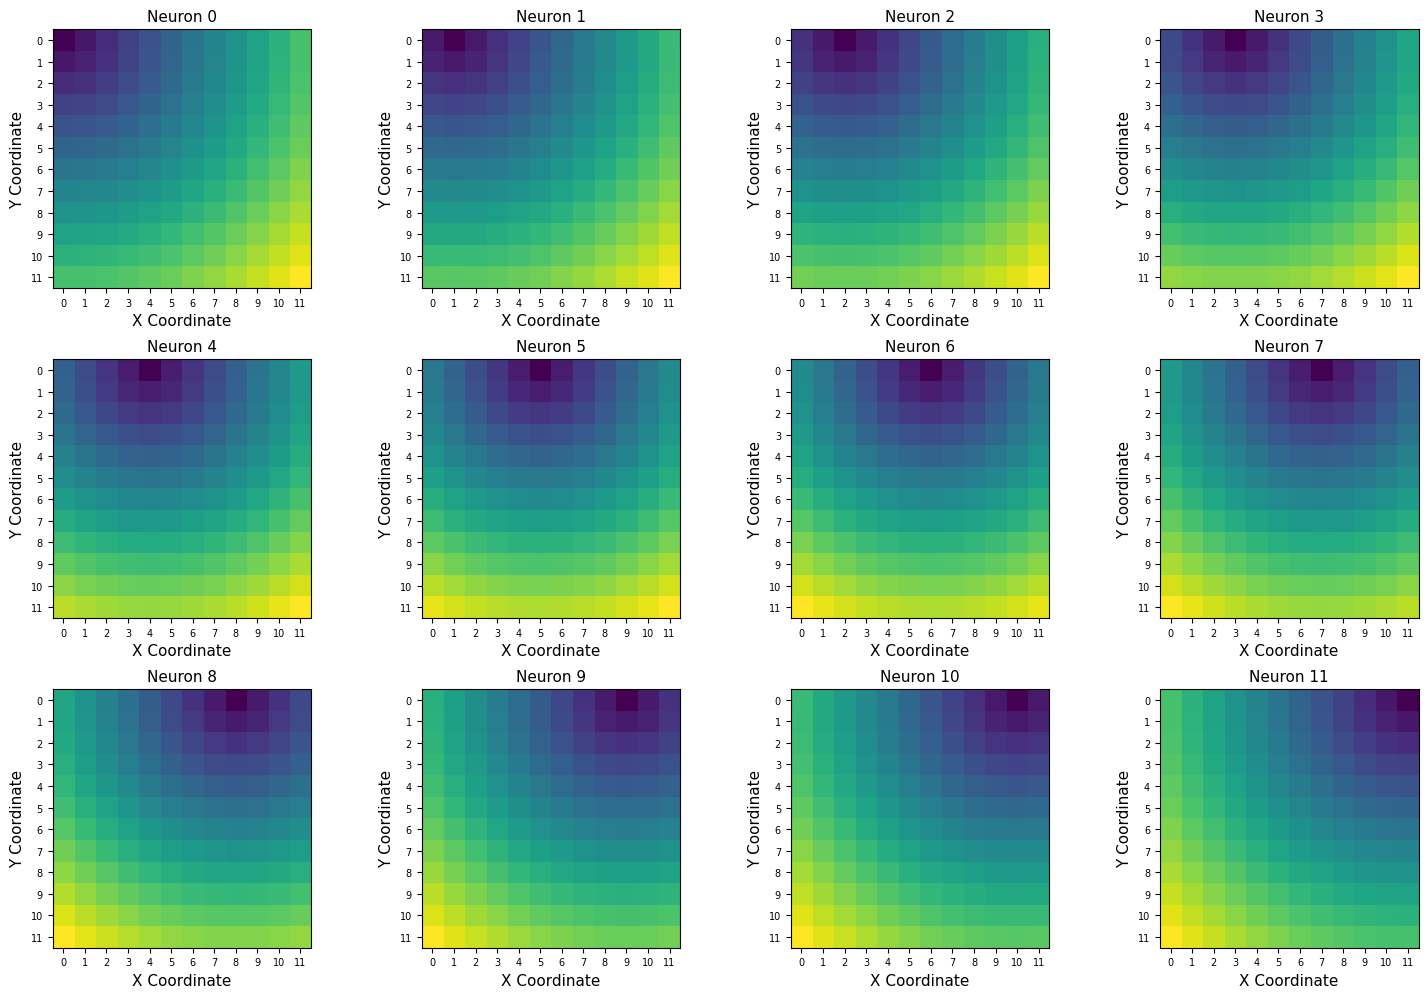

In [6]:
# @title Plotting individual neuron distance maps
# `locs` stores the x, y coordinates for each of the hidden units
locs =  np.array([[i, j] for i in range(w) for j in range(w)])
locs_str = ["%d, %d" % (i, j) for i, j in locs]

# We'll calculate the pairwise distances to other neurons for each of the 144 neurons
rnn_distances = np.zeros(net_leaky.rnn.h2h.weight.data.shape)
for i in range(len(locs)):
    rnn_distances[i, :] = np.sqrt((locs[i, 0] - locs[:, 0]) ** 2 + (locs[i, 1] - locs[:, 1]) ** 2)

# Plot individual neuron distance maps in 3 rows of 4
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(rnn_distances[i, :].reshape((w, w)), cmap="viridis")
    plt.title(f"Neuron {i}", fontsize = 11)
    plt.xlabel("X Coordinate", fontsize = 11)
    plt.ylabel("Y Coordinate", fontsize = 11)
    plt.xticks(range(w))
    plt.yticks(range(w))

plt.tight_layout()
plt.show()


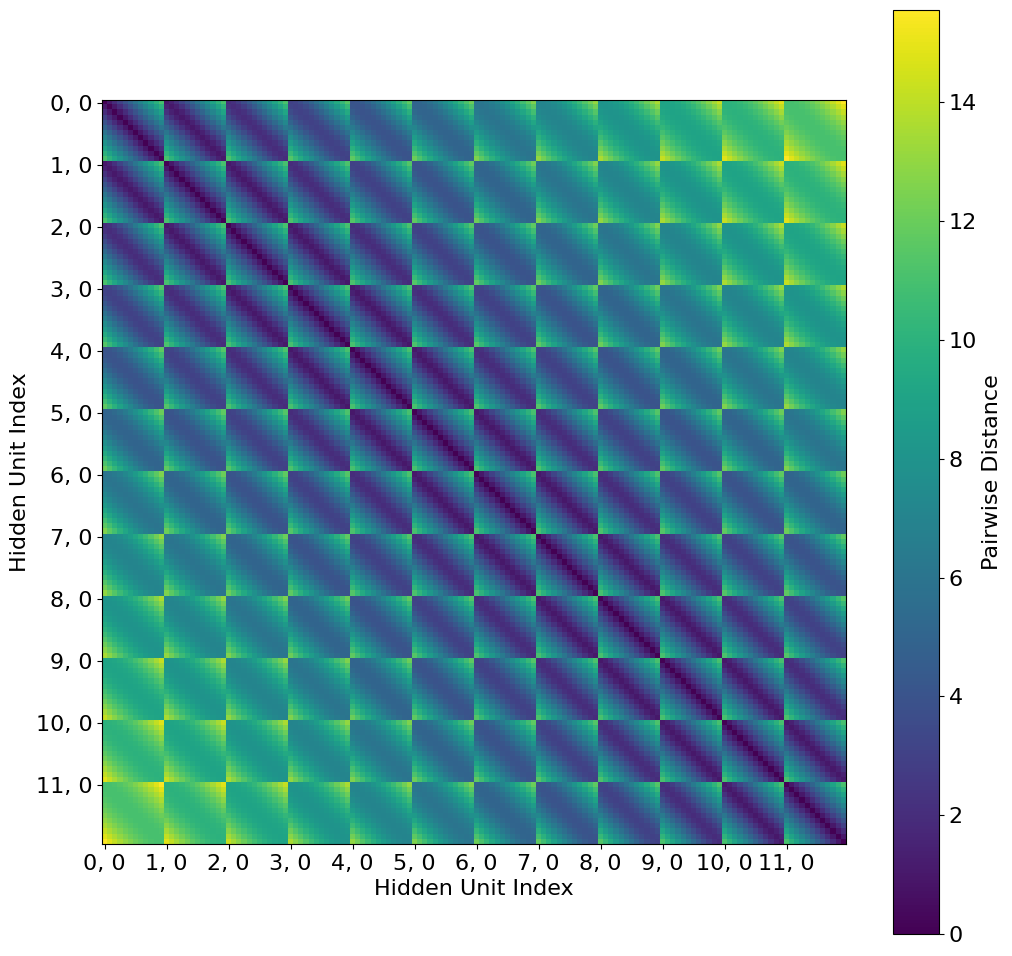

In [23]:
# @title Plotting entire distance matrix
# Instantiate the networks
hidden_size = 144

net_leaky = RNNNet(input_size=input_size, hidden_size=hidden_size,
            output_size=output_size, dt=env.dt)
w = int(np.sqrt(net_leaky.rnn.h2h.weight.data.shape[0]))

# `locs` stores the x, y coordinates for each of the hidden units
locs =  np.array([[i, j] for i in range(w) for j in range(w)])
locs_str = ["%d, %d" % (i, j) for i, j in locs]

# Calculate the pairwise distances to other units for each of the 144 units
rnn_distances = np.zeros(net_leaky.rnn.h2h.weight.data.shape)
for i in range(len(locs)):
    rnn_distances[i, :] = np.sqrt((locs[i, 0] - locs[:, 0]) ** 2 + (locs[i, 1] - locs[:, 1]) ** 2)

plt.figure(figsize=(12, 12))
plt.imshow(rnn_distances, cmap="viridis")
cbar = plt.colorbar()
cbar.set_label('Pairwise Distance', fontsize = 16)
cbar.ax.tick_params(labelsize = 16)
plt.xlabel("Hidden Unit Index", fontsize = 16)
plt.ylabel("Hidden Unit Index", fontsize = 16)
_ = plt.yticks(np.arange(0, w ** 2, w), labels=locs_str[::w], fontsize=16)
_ = plt.xticks(np.arange(0, w ** 2, w), labels=locs_str[::w], fontsize=16)
#plt.title("Pairwise Distance Matrix for All units", fontsize = 14)

Text(0.5, 1.0, 'Standard Leaky RNN pre-training')

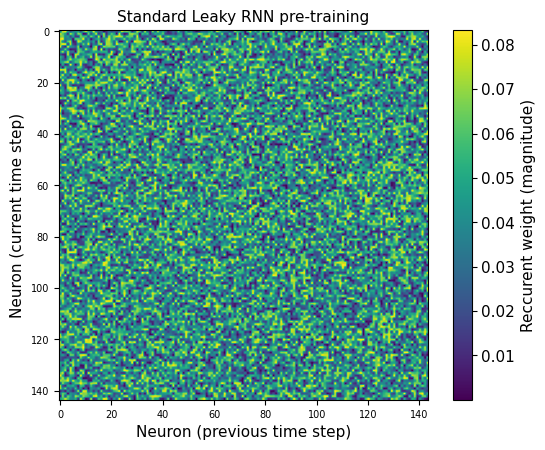

In [24]:
# @title Plotting recurrent weights pre-training
plt.imshow(np.abs(net_leaky.rnn.h2h.weight.data.numpy()))
cbar = plt.colorbar()
cbar.set_label('Reccurent weight (magnitude)', fontsize = 11)
cbar.ax.tick_params(labelsize = 11)
plt.xlabel("Neuron (previous time step)", fontsize = 11)
plt.ylabel("Neuron (current time step)", fontsize = 11)
plt.title("Standard Leaky RNN pre-training", fontsize = 11)

In [7]:
# @title PCA function
from sklearn.decomposition import PCA
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)
def perform_pca_analysis(network_name, activity_dict, trial_infos, num_trial=500, plot_until_time=70):
    """
    Performs PCA on the neural activity data and plots the results.

    Args:
        network_name (str): Name of the network
        activity_dict (dict): Dictionary containing neural activity for each trial.
        trial_infos (dict): Dictionary containing trial information.
        num_trial (int): Number of trials to include in the analysis.
        plot_until_time (int): Number of time steps to plot for each trial.
    """
    print(f"Performing PCA analysis on {network_name} network...")

    # Concatenate activity data across all trials for PCA
    activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
    print(f'Shape of the neural activity (Time points, Neurons) for {network_name}: {activity.shape}')

    # Initialize PCA and fit on the activity data
    pca = PCA(n_components=2)
    pca.fit(activity)
    print(f'Explained variance ratio (PC1 & PC2) for {network_name}: {pca.explained_variance_ratio_}')

    # Visualization
    fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

    # Plot for the first 5 trials, 10 trials, and 50 trials
    for j, num_trials in enumerate([5, 10, 50]):
        ax = axs[j]
        for i in range(num_trials):
            # Transform and plot each trial's activity
            activity_pc = pca.transform(activity_dict[i])

            # Determine the color based on ground truth
            trial = trial_infos[i]
            color = 'red' if trial['ground_truth'] == 0 else 'blue'

            ax.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

            # Indicate trial start with a different marker
            ax.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

        # Set labels and titles for clarity
        ax.set_title(f'{network_name} - {num_trials} Trials', fontsize=11)
        ax.set_xlabel('PC 1', fontsize=11)
        ax.set_ylabel('PC 2', fontsize=11)

    plt.tight_layout()
    plt.show()

In [8]:
# @title Test function
def test_model(network, env, num_trials=1000):
    """Test a given network and record activity, trial info, and stimulus selectivity.

    Args:
        network: a trained PyTorch RNN network.
        env: the environment object.
        num_trial: number of trials to test.

    Returns:
        activity_dict: dictionary of neural activity for each trial.
        trial_infos: dictionary of trial information.
        avg_perf: average performance of the network.
        stim_activity: list of neural activity during the stimulus for ground truth 0 and 1.
    """
    # Reset environment and adjust timing for stimulus and fixation periods
    env.reset(no_step=True)
    env.timing.update({'fixation': ('constant', 500), 'stimulus': ('constant', 500)})

    network.eval()

    # Initialize variables for logging
    activity_dict = {}
    trial_infos = {}
    stim_activity = [[], []]
    correct_trials = 0

    for i in range(num_trials):
        # Generate a new trial
        env.new_trial()
        ob, gt = env.ob, env.gt

        # Prepare inputs for the network
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        action_pred, rnn_activity = network(inputs)

        # Compute performance
        action_pred = action_pred.detach().numpy()
        choice = np.argmax(action_pred[-1, 0, :])
        correct = choice == gt[-1]
        if correct:
            correct_trials += 1

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        trial_infos[i] = trial_info

        # Record neural activity for the entire trial
        rnn_activity = rnn_activity[:, 0, :].detach().numpy()
        activity_dict[i] = rnn_activity

        # Extract activity during the stimulus period for selectivity analysis
        stim_activity_slice = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
        stim_activity[env.trial['ground_truth']].append(stim_activity_slice)

    # Calculate average performance
    avg_perf = correct_trials / num_trials

    return activity_dict, trial_infos, avg_perf, stim_activity

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average performance pre-training: 0.508
Performing PCA analysis on Leaky RNN network...
Shape of the neural activity (Time points, Neurons) for Leaky RNN: (27500, 144)
Explained variance ratio (PC1 & PC2) for Leaky RNN: [0.65461    0.23902956]


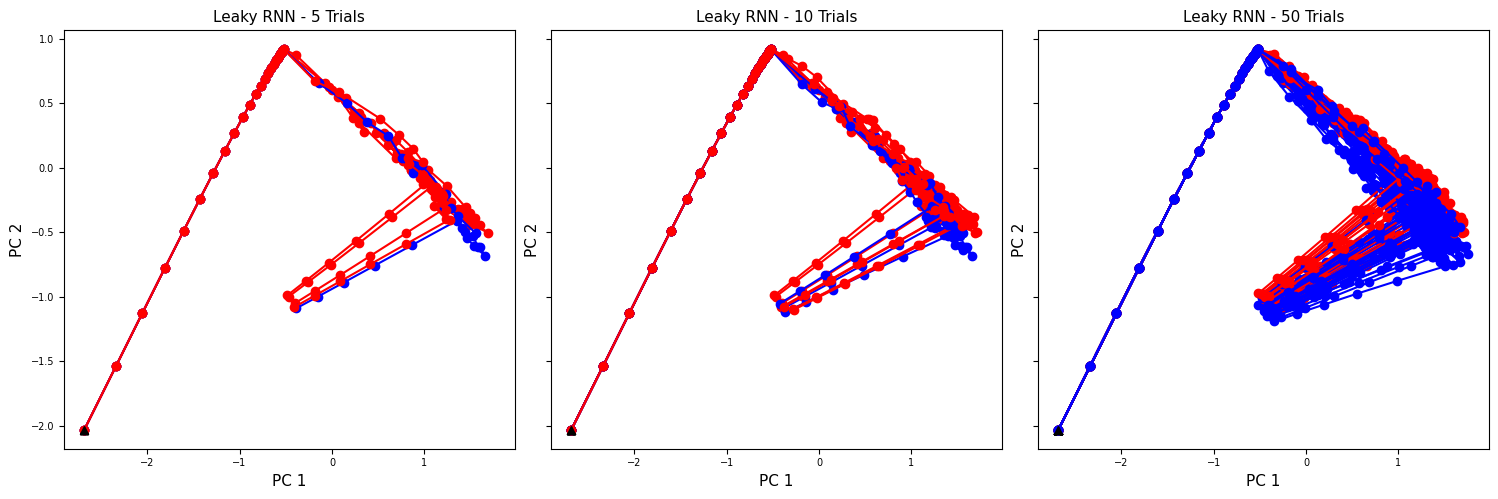

In [9]:
# @title Testing leaky RNN pre-training and plotting the pre-training PCA
activity_dict, trial_infos, avg_perf, _ = test_model(net_leaky, env)
print('Average performance pre-training:', avg_perf)
perform_pca_analysis('Leaky RNN', activity_dict, trial_infos)

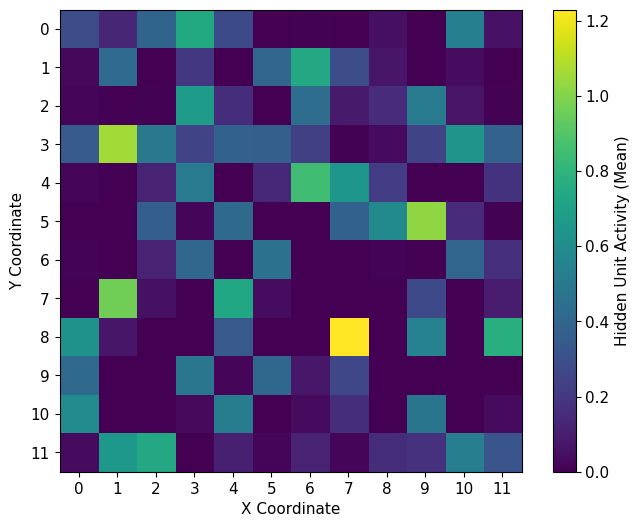

In [10]:
# @title Plotting the spatial distribution of hidden unit activity pre-training
def plot_spatial_activity(activity_dict, grid_size, aggregation='mean', trial_range=None):
    """
    Plots the spatial distribution of hidden unit activity.

    Args:
        activity_dict: Dictionary containing hidden unit activity for each trial.
        grid_size: Tuple (rows, cols) representing the spatial layout of hidden units.
        aggregation: Aggregation method ('mean' or 'max') for activity.
        trial_range: Range of trials to consider (list or range object), defaults to all trials.
    """
    # Initialize an array to store aggregated activity for each hidden unit
    num_units = grid_size[0] * grid_size[1]
    unit_activity = np.zeros(num_units)

    # Determine trials to process
    if trial_range is None:
        trial_range = range(len(activity_dict))

    # Aggregate activity over trials and time
    for trial in trial_range:
        trial_activity = activity_dict[trial]  # Shape: (time_steps, num_hidden_units)
        if aggregation == 'mean':
            unit_activity += np.mean(trial_activity, axis=0)
        elif aggregation == 'max':
            unit_activity += np.max(trial_activity, axis=0)

    # Normalize activity
    unit_activity /= len(trial_range)

    # Reshape into the grid for spatial visualization
    activity_grid = unit_activity.reshape(grid_size)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(activity_grid, cmap="viridis", origin="upper")
    cbar = plt.colorbar()
    cbar.set_label(f"Hidden Unit Activity ({aggregation.capitalize()})", fontsize = 11)
    cbar.ax.tick_params(labelsize = 11)
    #plt.title("Spatial Distribution of Hidden Unit Activity pre-training")
    plt.xlabel("X Coordinate", fontsize = 11)
    plt.ylabel("Y Coordinate", fontsize = 11)
    plt.xticks(range(grid_size[1]), fontsize = 11)
    plt.yticks(range(grid_size[0]), fontsize = 11)
    plt.show()

# 12x12 grid for hidden units
plot_spatial_activity(activity_dict, grid_size=(12, 12), aggregation='mean')

In [28]:
# @title Plotting the temporal dynamics of hidden unit activity pre-training
def plot_temporal_activity(activity_dict, grid_size, trial_range=None):
    """
    Plots the temporal dynamics of hidden unit activity across trials.

    Args:
        activity_dict: Dictionary containing hidden unit activity for each trial.
        grid_size: Tuple (rows, cols) representing the spatial layout of hidden units.
        trial_range: Range of trials to consider (list or range object), defaults to all trials.
    """
    # Determine trials to process
    if trial_range is None:
        trial_range = range(len(activity_dict))

    num_trials = len(trial_range)
    num_units = grid_size[0] * grid_size[1]

    # Initialize a figure for plotting
    plt.figure(figsize=(15, 8))

    # Plot activity for each unit across all trials
    for unit_index in range(num_units):
        plt.subplot(grid_size[0], grid_size[1], unit_index + 1)

        # Plot the activity for the current unit across trials
        for trial in trial_range:
            trial_activity = activity_dict[trial]  # Shape: (time_steps, num_hidden_units)
            plt.plot(trial_activity[:, unit_index], color='gray', alpha=0.5)  # Temporal activity over time

        plt.title(f"Unit {unit_index}")
        plt.xlabel("Time Steps")
        plt.ylabel("Activity")
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Call the function with your activity_dict and grid_size (e.g., (12, 12))
plot_temporal_activity(activity_dict, grid_size=(12, 12))

In [11]:
# @title Training model
def train_model(net, dataset, num_steps=2000):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
        loss_values: list of loss values for each step
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    net.train()

    running_loss = 0
    running_acc = 0
    start_time = time.time()

    loss_values = []
    # Loop over training batches
    print('Training network...')
    for i in range(num_steps):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            loss_values.append(running_loss)
            running_loss = 0

    return net, loss_values

# Dictionary to store networks and their corresponding loss values
trained_networks = {}
loss_dict = {}

# Train each network and save the loss values
trained_networks['Leaky'], loss_dict['Leaky'] = train_model(net_leaky, dataset)

Training network...
Step 100, Loss 0.2835, Time 7.7s
Step 200, Loss 0.1165, Time 14.2s
Step 300, Loss 0.0906, Time 19.4s
Step 400, Loss 0.0815, Time 24.0s
Step 500, Loss 0.0746, Time 30.4s
Step 600, Loss 0.0685, Time 34.9s
Step 700, Loss 0.0639, Time 40.3s
Step 800, Loss 0.0621, Time 45.8s
Step 900, Loss 0.0585, Time 50.5s
Step 1000, Loss 0.0593, Time 56.8s
Step 1100, Loss 0.0589, Time 61.5s
Step 1200, Loss 0.0565, Time 66.7s
Step 1300, Loss 0.0590, Time 72.2s
Step 1400, Loss 0.0561, Time 77.4s
Step 1500, Loss 0.0548, Time 83.2s
Step 1600, Loss 0.0562, Time 88.4s
Step 1700, Loss 0.0553, Time 93.3s
Step 1800, Loss 0.0559, Time 99.3s
Step 1900, Loss 0.0552, Time 104.0s
Step 2000, Loss 0.0590, Time 110.2s


In [12]:
# @title Train model, adding spatial loss
def train_model_spatial(net, dataset, num_steps=2000, rnn_distances=rnn_distances,
                spatial_coef=1e-3):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair
        rnn_distances: a 144x144 matrix of pairwise distances
        spatial_coef: coefficient for the spatial loss

    Returns:
        net: network object after training
        loss_values: list of loss values for each step
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    net.train()

    running_loss = 0
    running_acc = 0
    start_time = time.time()

    rnn_distances = torch.tensor(rnn_distances).float()

    loss_values = []
    # Loop over training batches
    print('Training network...')
    for i in range(num_steps):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        task_loss = criterion(output, labels)
        # Spatial loss
        spatial_loss = spatial_coef * torch.sum(torch.abs(net.rnn.h2h.weight) * rnn_distances)

        loss = task_loss + spatial_loss
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            loss_values.append(running_loss)
            running_loss = 0

    return net, loss_values

# Make a copy of the Leaky RNN as to not overwrite the weights
net_leaky_spatial = RNNNet(input_size=input_size, hidden_size=hidden_size,
            output_size=output_size, dt=env.dt)

# Train network and save the loss values
trained_networks['Leaky spatial'], loss_dict['Leaky spatial'] = train_model_spatial(net_leaky_spatial, dataset)

Training network...
Step 100, Loss 0.8108, Time 5.4s
Step 200, Loss 0.2901, Time 11.6s
Step 300, Loss 0.2619, Time 16.2s
Step 400, Loss 0.2513, Time 22.2s
Step 500, Loss 0.2401, Time 27.0s
Step 600, Loss 0.2316, Time 32.2s
Step 700, Loss 0.2275, Time 38.0s
Step 800, Loss 0.2314, Time 43.3s
Step 900, Loss 0.2255, Time 48.8s
Step 1000, Loss 0.2230, Time 54.2s
Step 1100, Loss 0.2203, Time 58.8s
Step 1200, Loss 0.2176, Time 64.9s
Step 1300, Loss 0.2144, Time 69.7s
Step 1400, Loss 0.2163, Time 74.8s
Step 1500, Loss 0.2174, Time 82.0s
Step 1600, Loss 0.2153, Time 86.6s
Step 1700, Loss 0.2147, Time 92.9s
Step 1800, Loss 0.2133, Time 97.5s
Step 1900, Loss 0.2111, Time 103.4s
Step 2000, Loss 0.2122, Time 108.8s


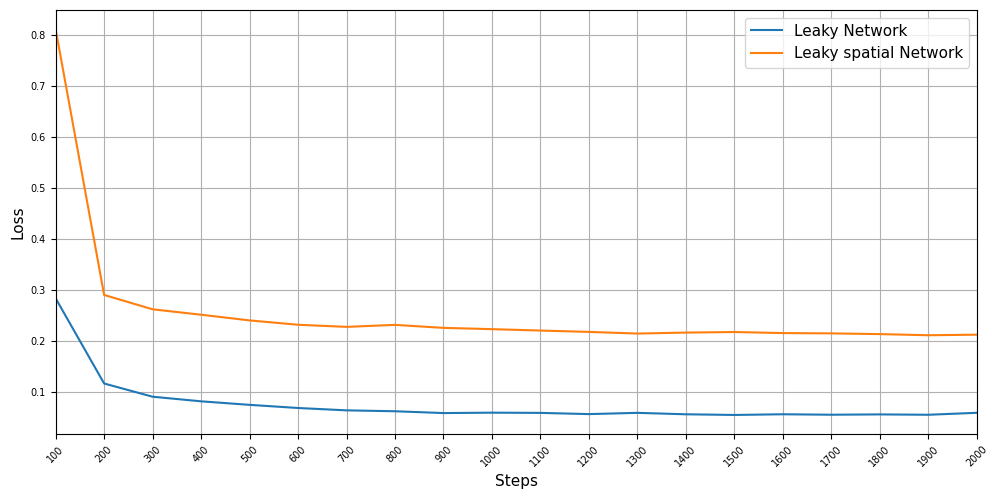

In [13]:
# @title Plotting the learning
# Set the default font to a safer option (like DejaVu Sans)
plt.rcParams['font.family'] = 'DejaVu Sans'

# Plotting the learning curve
plt.figure(figsize=(10,5))
for name, loss_values in loss_dict.items():
  steps = np.arange(100, 100 * (len(loss_values) + 1), 100)
  plt.plot(steps, loss_values, label=f'{name} Network')
#plt.title("Learning Curve", fontsize = 11)
plt.xlabel("Steps", fontsize = 11)
plt.ylabel("Loss", fontsize = 11)
plt.legend(fontsize = 11)
plt.grid(True)

plt.xticks(steps, rotation=45)
plt.xlim(steps[0], steps[-1])
plt.tight_layout()

plt.show()

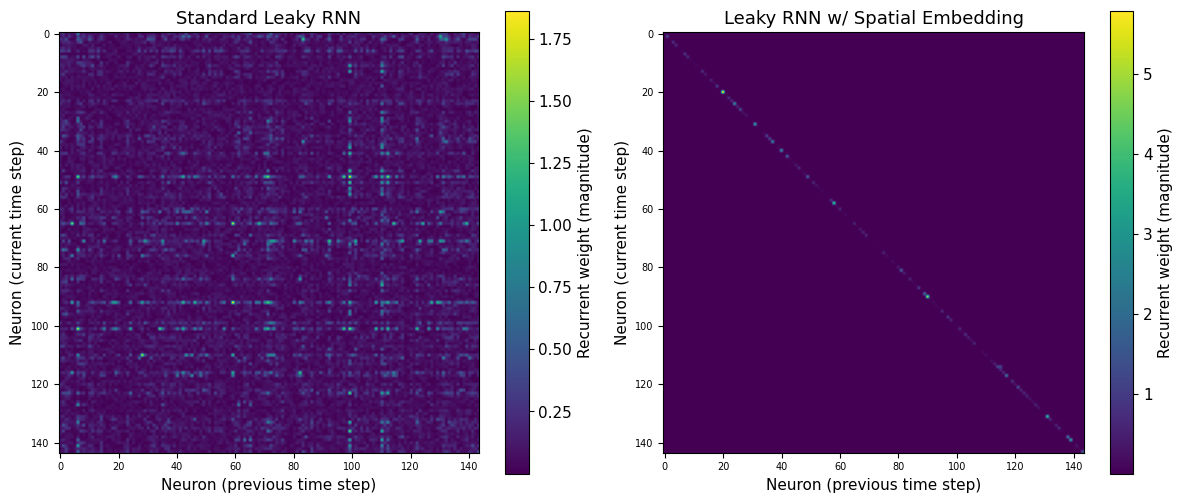

In [14]:
# @title Plotting the recurrent weights post-training
# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot for the standard leaky RNN
im1 = axes[0].imshow(np.abs(trained_networks['Leaky'].rnn.h2h.weight.data.numpy()))
cbar1 = fig.colorbar(im1, ax=axes[0])
cbar1.set_label('Recurrent weight (magnitude)', fontsize=11)
cbar1.ax.tick_params(labelsize=11)
axes[0].set_title("Standard Leaky RNN", fontsize=13)
axes[0].set_xlabel("Neuron (previous time step)", fontsize=11)
axes[0].set_ylabel("Neuron (current time step)", fontsize=11)

# Plot for the leaky RNN with spatial embedding
im2 = axes[1].imshow(np.abs(trained_networks['Leaky spatial'].rnn.h2h.weight.data.numpy()))
cbar2 = fig.colorbar(im2, ax=axes[1])
cbar2.set_label('Recurrent weight (magnitude)', fontsize=11)
cbar2.ax.tick_params(labelsize=11)
axes[1].set_title("Leaky RNN w/ Spatial Embedding", fontsize=13)
axes[1].set_xlabel("Neuron (previous time step)", fontsize=11)
axes[1].set_ylabel("Neuron (current time step)", fontsize=11)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

Average performance post-training 0.843
Performing PCA analysis on Leaky RNN network...
Shape of the neural activity (Time points, Neurons) for Leaky RNN: (27500, 144)
Explained variance ratio (PC1 & PC2) for Leaky RNN: [0.50312734 0.21516189]


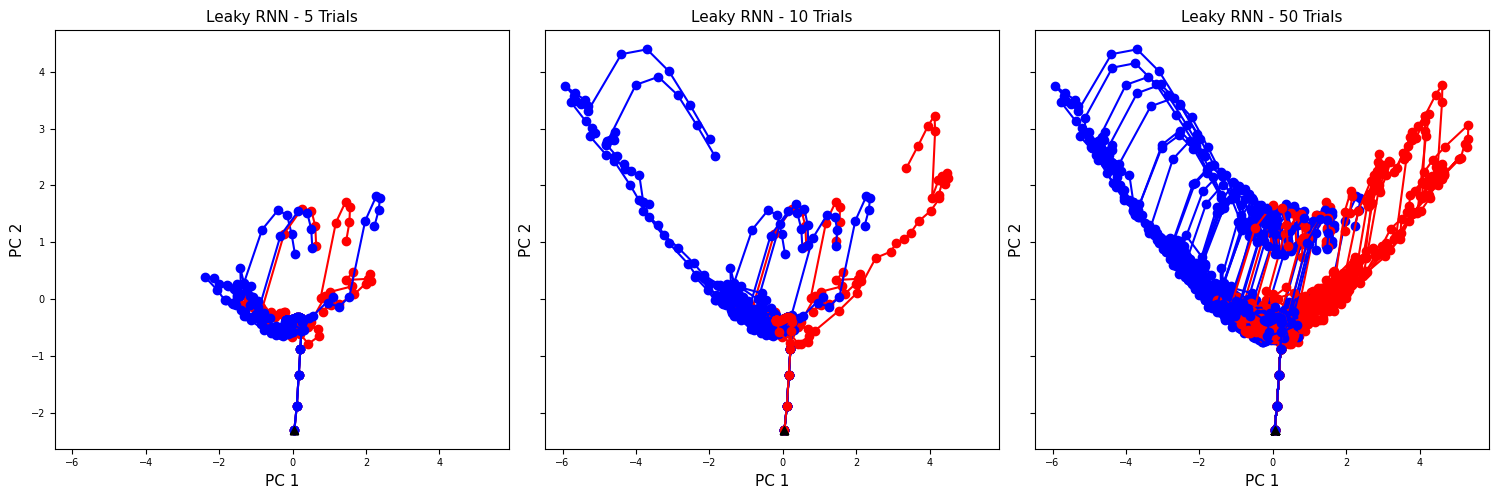

In [15]:
# @title Testing leaky RNN post-training and plotting the post-training PCA
activity_dict_post, trial_infos, avg_perf, _ = test_model(trained_networks['Leaky'], env)
print('Average performance post-training', avg_perf)
perform_pca_analysis('Leaky RNN', activity_dict_post, trial_infos)

<ipython-input-28-1deb03d57261>:37: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


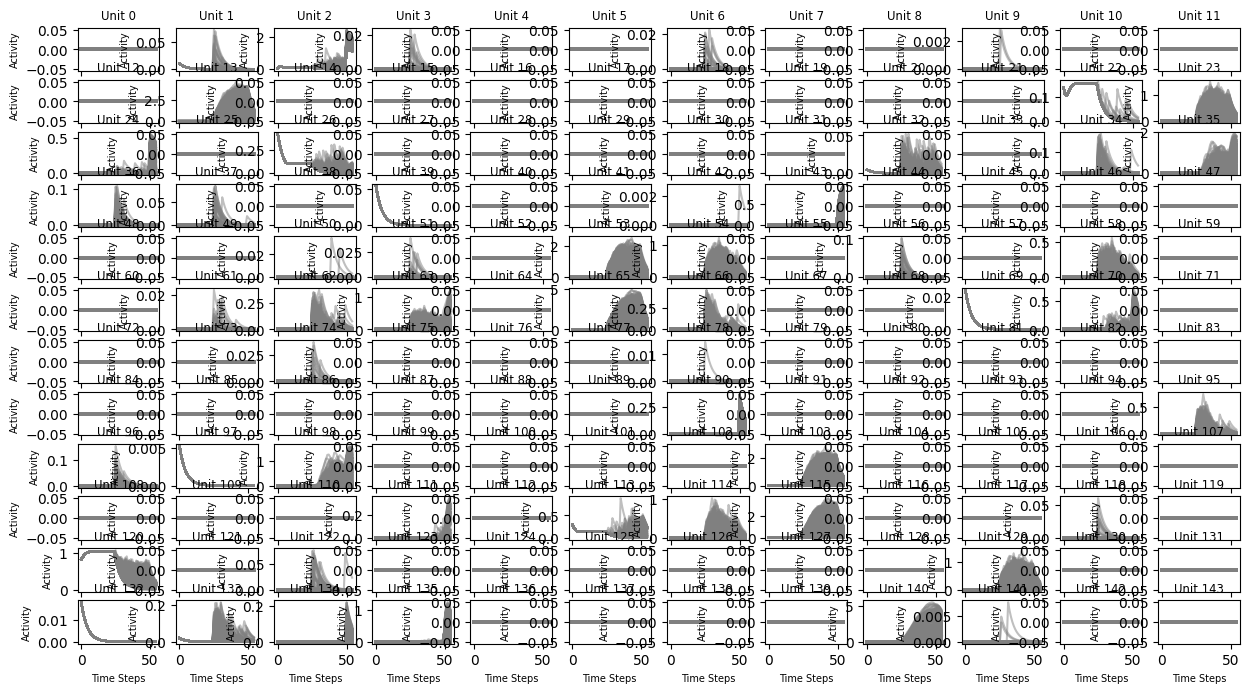

In [29]:
# @title Plotting the temporal dynamics of hidden unit activity post-training
plot_temporal_activity(activity_dict_post, grid_size=(12, 12))

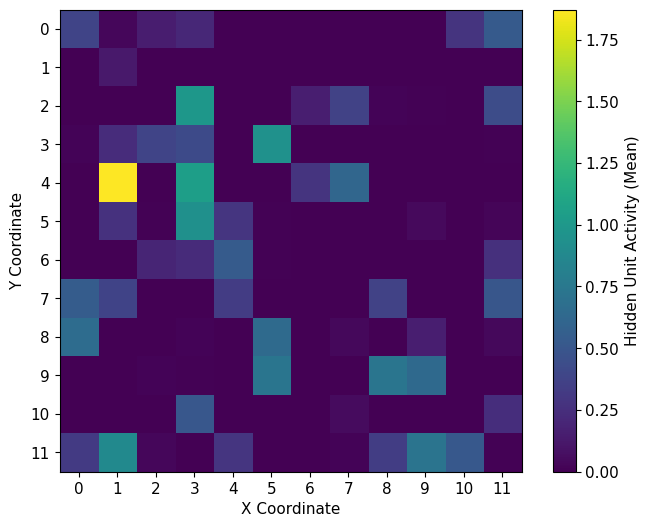

In [16]:
# @title Plotting the spatial distribution of hidden unit activity post-training
plot_spatial_activity(activity_dict_post, grid_size=(12, 12), aggregation='mean')

Average performance post-training 0.847
Performing PCA analysis on Leaky RNN with spatial embedding network...
Shape of the neural activity (Time points, Neurons) for Leaky RNN with spatial embedding: (27500, 144)
Explained variance ratio (PC1 & PC2) for Leaky RNN with spatial embedding: [0.44697613 0.2804703 ]


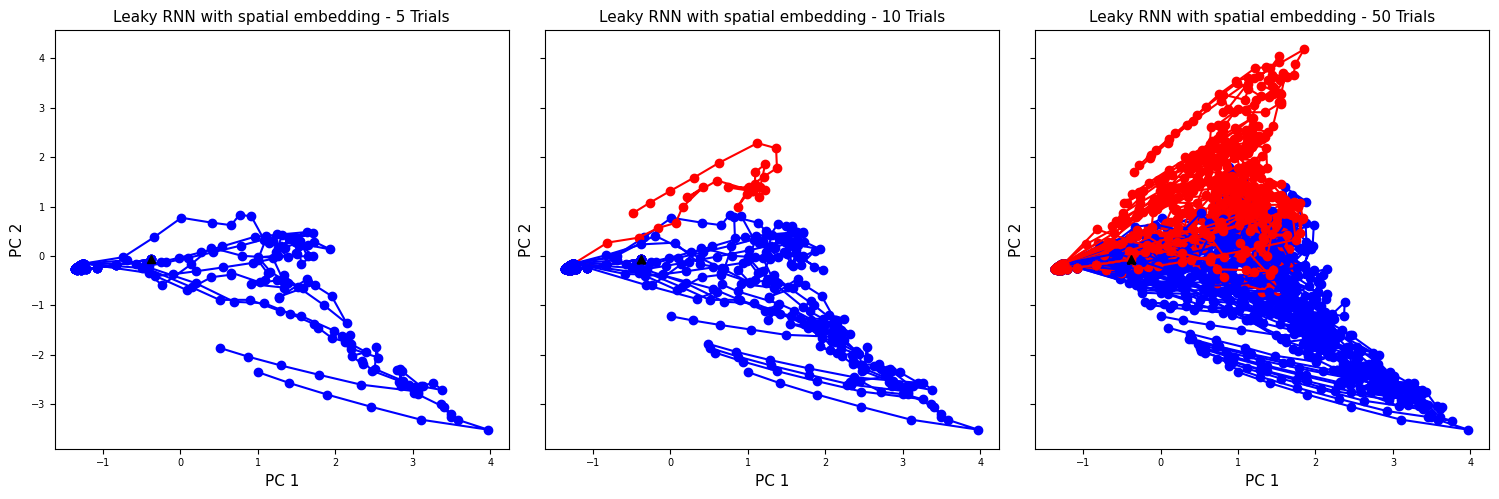

In [17]:
# @title Testing leaky RNN (w/ spatial embedding) post-training and plotting the post-training PCA
activity_dict_spa, trial_infos, avg_perf, _ = test_model(trained_networks['Leaky spatial'], env)
print('Average performance post-training', avg_perf)
perform_pca_analysis('Leaky RNN with spatial embedding', activity_dict_spa, trial_infos)

<ipython-input-28-1deb03d57261>:37: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


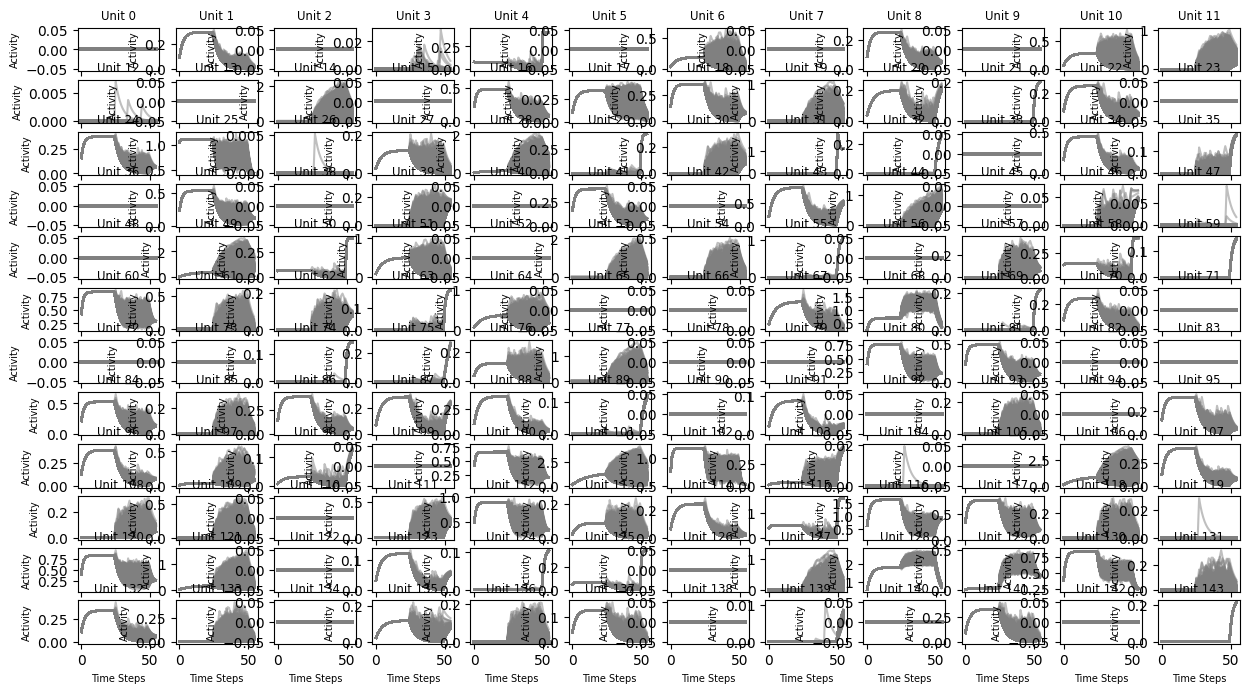

In [31]:
# @title Plotting the temporal dynamics of hidden unit activity post-training with spatial constraint
plot_temporal_activity(activity_dict_spa, grid_size=(12, 12))

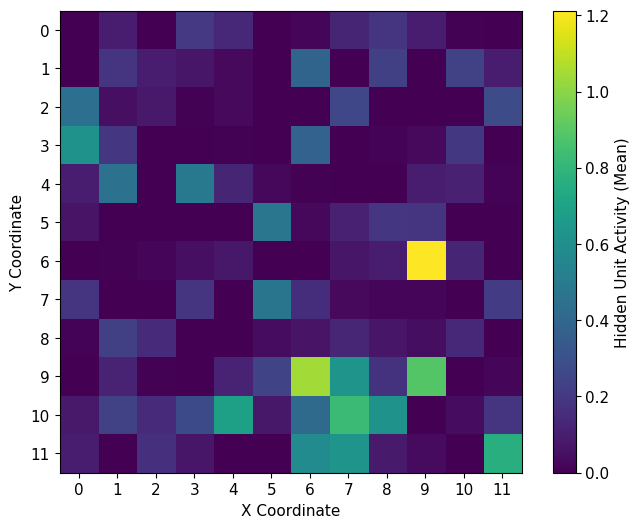

In [18]:
# @title Plotting the spatial distribution of hidden unit activity post-training with spatial constraint
plot_spatial_activity(activity_dict_spa, grid_size=(12, 12), aggregation='mean')

ERROR: Could not find a version that satisfies the requirement fixed-point-finder-master (from versions: none)
ERROR: No matching distribution found for fixed-point-finder-master

Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 8.01e-13 +/- 1.40e-12
		dq = 5.95e-15 +/- 7.92e-15
		learning rate = 4.58e-03
		avg iter time = 2.95e-03 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



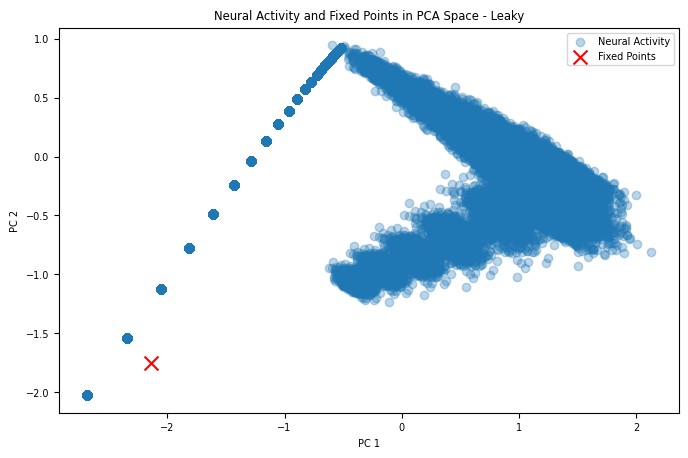

In [20]:
# @title Fixed Point analysis

!pip install fixed-point-finder-master

import sys
sys.path.append('/content/fixed-point-finder-master')

# Import the FixedPointFinderTorch class
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch

class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        # EI-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, hidden)

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden.unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden

# Instantiate the FixedPointRNNWrapper with the EI-RNN model from Net
rnn_model_fixed_point = FixedPointRNNWrapper(trained_networks['Leaky'].rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped EI-RNN model
finder = FixedPointFinder(rnn_model_fixed_point)

# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, trained_networks['Leaky'].rnn.hidden_size)  # 10 random initial hidden states
inputs = torch.zeros(10, trained_networks['Leaky'].rnn.input_size)  # Zero input for each initial condition

# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

# Run fixed-point finding using the wrapped model
fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute

# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Neural Activity and Fixed Points in PCA Space - Leaky")
plt.legend()
plt.show()


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		315 iters
		q = 7.28e-14 +/- 9.59e-14
		dq = 6.63e-13 +/- 1.97e-12
		learning rate = 6.60e-02
		avg iter time = 8.38e-03 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



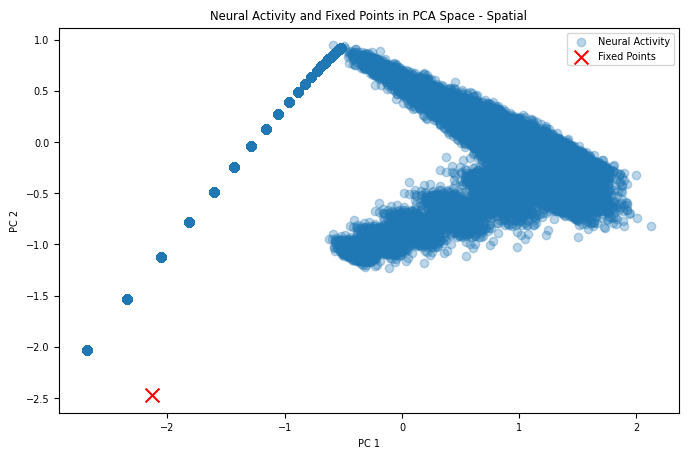

In [21]:
# Instantiate the FixedPointRNNWrapper with the EI-RNN model from Net
rnn_model_fixed_point = FixedPointRNNWrapper(trained_networks['Leaky spatial'].rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped EI-RNN model
finder = FixedPointFinder(rnn_model_fixed_point)

# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, trained_networks['Leaky spatial'].rnn.hidden_size)  # 10 random initial hidden states
inputs = torch.zeros(10, trained_networks['Leaky spatial'].rnn.input_size)  # Zero input for each initial condition

# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

# Run fixed-point finding using the wrapped model
fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute

# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Neural Activity and Fixed Points in PCA Space - Spatial")
plt.legend()
plt.show()